# PISCES wavelength calibration

We have PISCES VARIA calibration sets. We will show how to process them to build a new wavelength calibration

In [1]:
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Import crispy-related stuff

In [2]:
import sys
codefolder = '../../../../crispy'
if codefolder not in sys.path: sys.path.append(codefolder)
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
from crispy.PISCESparams import Params
codefolder = '../../../crispy'
par = Params(codefolder)

## Import files and subtract darks

In [3]:
allfiles = glob.glob("/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407*.fits")
print allfiles
darks= [f for f in allfiles if "dark" in f]
dark = np.zeros(Image(darks[0]).data.shape)
for d in darks:
    dark += Image(d).data
dark/=len(darks)
Image(data=dark).write(par.wavecalDir+"dark.fits")


par.lamlist = np.arange(615.,720.,10)
par.filelist = []
for i in range(len(par.lamlist)):
    lam=par.lamlist[i]
    lamfiles = [f for f in allfiles if ("%dnm" % lam) in f]
    img = np.zeros(Image(lamfiles[0]).data.shape)
    for lamfile in lamfiles:
        img += Image(lamfile).data
    img /= len(lamfiles)
    img -= dark
    par.filelist+= [par.wavecalDir+"ave_cal_%dnm.fits" % lam]
    Image(data=img).write(par.filelist[i])


['/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_605nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_615nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_625nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_635nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_645nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_655nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_665nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_675nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_685nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_695nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_705nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_0_715nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_1_605nm.fits', '/Users/mrizzo/IFS/Calibra_170407_data/Calibra_170407_1_615nm.fits', '/Users/mrizzo/IFS/Calibra_170407

Image the last file

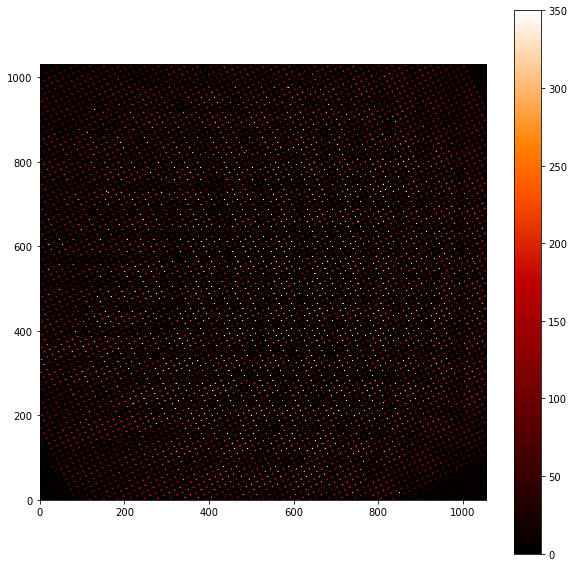

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(img,vmin=0, vmax=350, cmap='gist_heat')
plt.colorbar()
plt.show()

In [5]:
print(par.lamlist)

[ 615.  625.  635.  645.  655.  665.  675.  685.  695.  705.  715.]


## Build wavelength calibration files

In [6]:
from crispy.tools.wavecal import buildcalibrations
buildcalibrations(par,
                  inspect=True,
                  genwavelengthsol=True, # Compute wavelength at the center of all pixels
                  makehiresPSFlets=False) # do NOT make high-resolution PSFLets unless we have extremely good SNR

crispy - INFO - Building calibration files, placing results in ../../../crispy/ReferenceFiles/Calibra_170407/
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170407/ave_cal_615nm.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170407/ave_cal_615nm.fits
crispy - INFO - Initializing PSFlet location transformation coefficients
crispy - INFO - Performing initial optimization of PSFlet location transformation coefficients for frame ../../../crispy/ReferenceFiles/Calibra_170407/ave_cal_615nm.fits
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ../../../crispy/ReferenceFiles/Calibra_170407/ave_cal_615nm.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170407/ave_cal_625nm.fits
crispy - INFO - Initializing transformation coefficients with previous values
crispy - INFO - Performing final optimization of PSFlet location transformation coeffi

In [7]:
from crispy.IFS import reduceIFSMap
cube = reduceIFSMap(par,par.wavecalDir+'/ave_cal_655nm.fits')


crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170407//ave_cal_655nm.fits
crispy - INFO - Reduced cube will have 22 wavelength bins


/Users/mrizzo/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


crispy - INFO - Writing data to ../../../crispy/SimResults/ave_cal_655nm_red_optext.fits
crispy - INFO - Elapsed time: 13.825671s


In [12]:
import ipywidgets
def plt_ifs_optext(wchan):
    plt.imshow(cube.data[wchan-1,:,:],
               vmin=100, vmax=300, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_optext, wchan=(1,cube.data.shape[0]))


<function __main__.plt_ifs_optext>

In [9]:
cube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [10]:
par.lamlist = np.arange(615.,720.,10)

from crispy.tools.reduction import calculateWaveList
lam_midpts,lam_endpts = calculateWaveList(par)
print('Wavelengths at midpoints (nm): ',lam_midpts)
print('Wavelengths at endpoints (nm): ',lam_endpts)

crispy - INFO - Reduced cube will have 22 wavelength bins
('Wavelengths at midpoints (nm): ', array([ 617.27272727,  621.81818182,  626.36363636,  630.90909091,
        635.45454545,  640.        ,  644.54545455,  649.09090909,
        653.63636364,  658.18181818,  662.72727273,  667.27272727,
        671.81818182,  676.36363636,  680.90909091,  685.45454545,
        690.        ,  694.54545455,  699.09090909,  703.63636364,
        708.18181818,  712.72727273]))
('Wavelengths at endpoints (nm): ', array([ 615.        ,  619.54545455,  624.09090909,  628.63636364,
        633.18181818,  637.72727273,  642.27272727,  646.81818182,
        651.36363636,  655.90909091,  660.45454545,  665.        ,
        669.54545455,  674.09090909,  678.63636364,  683.18181818,
        687.72727273,  692.27272727,  696.81818182,  701.36363636,
        705.90909091,  710.45454545,  715.        ]))


## Monochromatic updates

## High-resolution PSFLets assuming Gaussian shape 

In [14]:
from crispy.tools.wavecal import buildcalibrations
par.gaussian_hires=False # since par.gaussian_hires is False, it will attempt to make high-resolution PSFLets
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
par.npixperdlam=0.8
buildcalibrations(par,
                    inspect=True,
                    genwavelengthsol=False, # Compute wavelength at the center of all pixels
                    makehiresPSFlets=True,
                    makePolychrome=True,
                    upsample=3,
                    nsubarr=4
                  ) 

crispy - INFO - Building calibration files, placing results in ../../../crispy/ReferenceFiles/Calibra_170425/
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det615.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det625.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det635.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det645.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det655.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det665.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det6

../../../../crispy/crispy/tools/wavecal.py:396: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  subim[k, iy::upsample, ix::upsample] = cutout
../../../../crispy/crispy/tools/wavecal.py:396: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  subim[k, iy::upsample, ix::upsample] = cutout
../../../../crispy/crispy/tools/wavecal.py:396: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  subim[k, iy::upsample, ix::upsample] = cutout
../../../../crispy/crispy/tools/wavecal.py:396: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  subim[k, iy::upsample, ix::upsample] = cutout
../../../../crispy/crispy/tools/wavecal.py:396: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the futur

crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Making polychrome cube
crispy - INFO - Saving polychrome cube
crispy - INFO - Saving wavelength calibration cube
crispy - INFO - Total time elapsed: 53 s


In [4]:
from crispy.tools.wavecal import monochromatic_update
from crispy.tools.image import Image
# let's pretend that we got a new file
inImage = Image(par.codeRoot+"/Inputs/Flat637.fits")
inLam = 637.
inImage = Image(par.wavecalDir+'det685.0.fits')
inLam=685.

# this does everything you want
monochromatic_update(par,inImage,inLam)


crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/Flat637.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - Making copies of wavelength solution from ../../../crispy/ReferenceFiles/Calibra_170425//lamsol.dat
crispy - INFO - Generating new wavelength solution
crispy - INFO - Initializing transformation coefficients with previous values
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ../../../crispy/ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - 0.35: x-shift from archival spot positions (pixels)
crispy - INFO - -0.59: y-shift from archival spot positions (pixels)
crispy - INFO - -0.00: rotation from archival spot positions (degrees)
crispy - INFO - Overwriting old wavecal
crispy - INFO - Reduced cube will have 13 wavelength bins


NameError: global name 'xsize' is not defined

In [15]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image
par.npixperdlam = 2
print par.npixperdlam

# dark = Image(par.codeRoot+'/Inputs/Dark_20s_170426.fits')
# img = Image(par.codeRoot+'/Inputs/Flat637nm_20s_170426.fits')
# Image(data=img.data-dark.data).write(par.codeRoot+"/Inputs/Flat637.fits")
#cube = reduceIFSMap(par,par.wavecalDir+'det675.0.fits',method='lstsq')
#cube = reduceIFSMap(par,par.codeRoot+"/Inputs/Flat637.fits",method='optext')
#cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='optext')

par.npixperdlam = 0.8
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/Flat637.fits",method='lstsq')
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq')


#cube = reduceIFSMap(par,par.wavecalDir+'polychromeR70stack.fits',method='optext')


2
crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/Flat637.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/Flat637_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/Flat637_red_lstsq_resid.fits
crispy - INFO - Elapsed time: 3.379326s
crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Elapsed time: 3.515273s
